## Classifying letters

This notebook contains a training script for a classifier that can recognize a few letters from a bitmap.
Version 2: uses data from the wand to validate ("transfer learning", if you will)

In [46]:
from datetime import datetime
from tqdm import tqdm
import numpy as np   # numpy==1.22.0 
from matplotlib import pyplot

from tensorflow.keras.models import Sequential  # tf v 2.10
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
# import tensorflow_io as tfio         //  not working in windows ?
# from tensorflow_addons import image  //  not working in windows ?
import tensorflow_addons as tfa
import pathlib
import shutil
from os import path
from pathlib import Path

from PIL import Image

%load_ext tensorboard

create new dataset from wand drawn images

In [47]:
# first, copy all images of same class to single dir
_LETTERS = 'LMCO'
# letter = 'M'     

IMG_HEIGHT = 32 
IMG_WIDTH =  IMG_HEIGHT
RO_ANG = np.pi/4
fill_value = 255

# img_res = tf.image.resize_bilinear(img_4d, (IMG_HEIGHT, IMG_WIDTH), align_corners=True)


def moveWandFiles(source_folder:pathlib.Path, target_folder:pathlib.Path,letter):
    target_folder= os.path.join(target_folder + letter )   
    source_folder= os.path.join(source_folder + letter )   
    Path(target_folder).mkdir(parents=True, exist_ok=True)
    ii = 0
    
    for image_file in tqdm(Path(source_folder).rglob("*.bmp")): # recursively find image paths
        # Separate base from extension
        base, extension = os.path.splitext(image_file.name)        
        new_name = os.path.join(letter + "_" + str(ii) + extension)    
        shutil.copy(image_file, Path(target_folder).joinpath(new_name))
        ii += 1        
        #  rotate 5 times
        
        for x in range(6):
            img = tf.keras.utils.load_img(Path(target_folder).joinpath(new_name))
            rotAng = tf.random.uniform(shape = [], minval = -(RO_ANG), maxval = RO_ANG)
            rotate = tfa.image.rotate(img, rotAng,'bilinear','constant',0.0)
            # img_cast = tf.cast(rotate,dtype=tf.uint8)
            # img_4d = tf.expand_dims(img_cast, axis=0)
            # img_res = tf.compat.v1.image.resize_bilinear(img_4d, (IMG_HEIGHT, IMG_WIDTH), align_corners=True)
            img_encoded = tf.compat.v1.image.encode_png(tf.cast(rotate, tf.uint8))
            # img_encoded = tf.compat.v1.image.encode_png(tf.cast(rotate, tf.uint16))
            
            extension ='.png'
            rotate_name = os.path.join(letter + str(ii-1) + "_r" + str(x) +"_"  + extension)   
            # print(rotate_name)
            file = tf.compat.v1.write_file(str(Path(target_folder).joinpath(rotate_name)), img_encoded)     
            # tfio.io.write_file(rotate_name, img_encoded)   
            
        
        
 
OG_lettersInD = 'C:\\Users\\john\\Documents\\Arduino\\priWand\\letters\\'      
destCollated = 'C:\\Users\\john\\Documents\\Arduino\\priWand\\priWand\\letters\\groupedWandLetters\\'  
# destCollated = '..\\letters\\groupedWandLetters'  


rootimage = OG_lettersInD
disdir = destCollated  

_LABELS = [ord(c) - ord('A') + 1 for c in _LETTERS ]
# labels = tf.constant(_LABELS, dtype=tf.int64)
# print("_LABELS = ",_LABELS)
# print("labels = ",labels) 
# print("_LETTERS = ",_LETTERS[2])


for letter in tqdm(_LETTERS):
    print("letter = ",str(letter))
    moveWandFiles(rootimage, disdir,letter)

print("images collated and rotated")





  0%|          | 0/4 [00:00<?, ?it/s]

letter =  L


288it [00:22, 12.85it/s]
 25%|██▌       | 1/4 [00:22<01:07, 22.41s/it]

letter =  M


75it [00:05, 14.25it/s]
 50%|█████     | 2/4 [00:27<00:24, 12.33s/it]

letter =  C


128it [00:09, 13.27it/s]
 75%|███████▌  | 3/4 [00:37<00:11, 11.10s/it]

letter =  O


86it [00:07, 11.70it/s]
100%|██████████| 4/4 [00:44<00:00, 11.17s/it]

images collated and rotated


tf.Tensor([12 13  3 15], shape=(4,), dtype=int64)
Found 4039 files belonging to 4 classes.


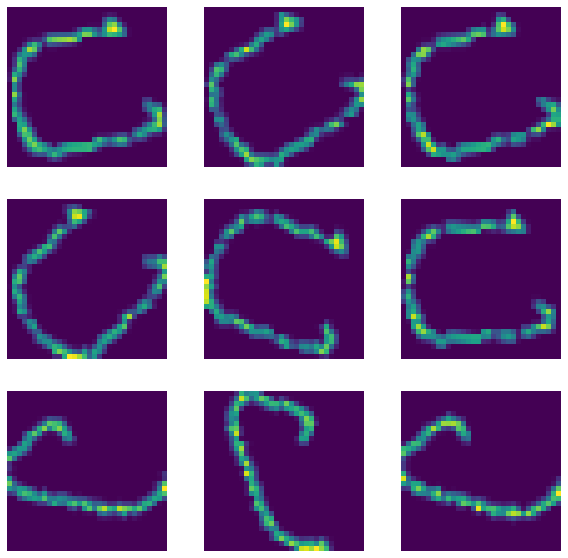

In [42]:
# _LETTERS = 'LMCO'

# Labels in the emnist/letters dataset that should be used for training.
_LABELS = [ord(c) - ord('A') + 1 for c in _LETTERS ]
labels = tf.constant(_LABELS, dtype=tf.int64)
print(labels)

# _WANTED_LABELS = [ord(c) - ord('A') + 1 for c in _LETTERS]
# _OTHER_LABEL = 0
# _NUM_CLASSES = len(_LETTERS) + 1  # All "other" letters classified as 0.
        
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    destCollated,
    labels="inferred",
    # label_mode="int",
    # class_names=labels,
    color_mode="grayscale",
    batch_size=32,
    image_size=(32, 32),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

pyplot.figure(figsize=(10, 10))
for images, _ in val_ds.take(1):
    # print("images=",images)
    # print(tf.strings.as_string(images))
    for i in range(9):
        # augmented_images = data_augmentation(images)
        ax = pyplot.subplot(3, 3, i + 1)
        fn = images[i].numpy().astype("uint8")
        # print("fn=",tf.strings.as_string(fn))
        pyplot.imshow(fn)
        pyplot.axis("off")
    
# pyplot.figure(figsize=(10, 10))
# for images, _ in val_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = pyplot.subplot(3, 3, i + 1)
#         pyplot.imshow(augmented_images[0].numpy().astype("uint8"))
#         pyplot.axis("off")

In [43]:
# Set of letters we want to recognized
# _LETTERS = 'MOCL'
# A set of letters used to train the "other" category. These shouldn't look
# similar to any of the letters in _LETTERS
_OTHER_LETTERS = 'FHIKRTY'


# Labels in the emnist/letters dataset that should be used for training.
_LABELS = [ord(c) - ord('A') + 1 for c in _LETTERS + _OTHER_LETTERS]

_WANTED_LABELS = [ord(c) - ord('A') + 1 for c in _LETTERS]
_OTHER_LABEL = 0
_NUM_CLASSES = len(_LETTERS) + 1  # All "other" letters classified as 0.
_BATCH_SIZE = 32

# load train and test dataset



def load_dataset():
    # load dataset
    (train_ds, test_ds), ds_info = tfds.load(
        name='emnist/letters',
        split=['train', 'test'],
        shuffle_files=True,
        with_info=True,
        as_supervised=True,
        decoders={
            # Don't decode images, the dataset will get filtered,
            # and we shouldn't decode what we don't use.
            'image': tfds.decode.SkipDecoding(),
        })


    # combined_dataset = dataset_1.concatenate(dataset_2)
    train_ds = prepare(train_ds, ds_info)
    test_ds = prepare(test_ds, ds_info)

    return (train_ds, test_ds), ds_info


def prepare(dataset, ds_info):
    labels = tf.constant(_LABELS, dtype=tf.int64)
    wanted_labels = tf.constant(_WANTED_LABELS, dtype=tf.int64)

    @tf.function
    def is_wanted(image, label):
        """Returns true if label is in _LABELS"""
        del image  # unused
        return tf.math.reduce_any(label == labels)

    @tf.function
    def map_entry(image, label):
        """Transforms the image into the form our classifier will expect."""
        decoded = ds_info.features['image'].decode_example(image)
        # Convert image to floats
        image = tf.cast(decoded, tf.float32) / 255
        # Images in emnist are transposed. Bring them back into normal direction.
        image = tf.transpose(image, perm=[1, 0, 2])
        label = tf.cond(
            tf.math.reduce_any(label == wanted_labels),
            # Relabel entries that are in _LETTERS to the range [1, len(_LETTERS)]
            lambda: tf.argmax(tf.equal(wanted_labels, label)) + 1,
            # Relabel entries in _OTHER_LETTERS to 0.
            lambda: tf.constant(_OTHER_LABEL, dtype=tf.int64))
        return image, label

    return (dataset.filter(is_wanted).cache().shuffle(1000).map(
        map_entry).batch(_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE))


def define_model():
    # Train with images that randomly rotated, in any direction. This is
    # because we can't tell the direction the wand is held.
    # If we could, we might get better classification by reducing the range of
    # random rotation.
    factor=0.2
    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomRotation(
            factor, interpolation='nearest'),
    ])
    model = Sequential()
    model.add(data_augmentation)
    model.add(
        layers.Conv2D(16, (3, 3),
                      activation='relu',
                      kernel_initializer='he_uniform',
                      input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(
        layers.Conv2D(32, (3, 3),
                      activation='relu',
                      kernel_initializer='he_uniform'))
    model.add(
        layers.Conv2D(32, (3, 3),
                      activation='relu',
                      kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(
        layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(_NUM_CLASSES))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    return model


# trains a model


def train_model(train_ds, test_ds):
    """Trains the model, and outputs evaluation stats to TensorBoard."""
    model = define_model()
    logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                     histogram_freq=1,
                                                     profile_batch='500,520')
    # fit model
    history = model.fit(train_ds,
                        epochs=10,
                        validation_data=test_ds,
                        callbacks=[tboard_callback],
                        class_weight=_label_weights(len(_LABELS),
                                                    _WANTED_LABELS))
    # evaluate model
    _, acc = model.evaluate(test_ds)
    print('> %.3f' % (acc * 100.0))
    return model, acc, history


# plot diagnostic learning curves


def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'],
                    color='orange',
                    label='test')
        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'],
                    color='blue',
                    label='train')
        pyplot.plot(histories[i].history['val_accuracy'],
                    color='orange',
                    label='test')
    pyplot.show()


# summarize model performance


def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' %
          (np.mean(scores) * 100, np.std(scores) * 100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()


# run the test harness for evaluating a model


def run_training():
    """Runs training and shows learning curves."""
    # load dataset
    (train_ds, test_ds), ds_info = load_dataset()
    # evaluate model
    model, score, history = train_model(train_ds, test_ds)
    # learning curves
    summarize_diagnostics([history])
    # summarize estimated performance
    summarize_performance([score])
    return model


def _label_weights(total_num_labels, wanted_labels):
    """Reweight the label costs to account over represented OTHER label."""
    label_weights = {
        l: 1.0 / (len(wanted_labels) + 1)
        for l in range(len(wanted_labels) + 1)
    }
    label_weights[_OTHER_LABEL] = (1.0 /
                                   ((len(wanted_labels) + 1) *
                                    (total_num_labels - len(wanted_labels))))
    return label_weights


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def blur(img_array):
    kernel = np.array([1, 3, 1])
    img_array = np.apply_along_axis(
        lambda x: np.convolve(x, kernel, mode='same'), 0, img_array)
    img_array = np.apply_along_axis(
        lambda x: np.convolve(x, kernel, mode='same'), 1, img_array)
    return img_array


Epoch 1/10


1177/1177 [==============================] - 27s 20ms/step - loss: 0.0366 - accuracy: 0.7775 - val_loss: 0.2844 - val_accuracy: 0.8718
Epoch 2/10
1177/1177 [==============================] - 22s 19ms/step - loss: 0.0193 - accuracy: 0.8644 - val_loss: 0.3637 - val_accuracy: 0.8458
Epoch 3/10
1177/1177 [==============================] - 23s 20ms/step - loss: 0.0159 - accuracy: 0.8812 - val_loss: 0.3284 - val_accuracy: 0.8594
Epoch 4/10
1177/1177 [==============================] - 22s 19ms/step - loss: 0.0145 - accuracy: 0.8886 - val_loss: 0.2540 - val_accuracy: 0.8781
Epoch 5/10
1177/1177 [==============================] - 22s 19ms/step - loss: 0.0135 - accuracy: 0.8922 - val_loss: 0.2385 - val_accuracy: 0.8942
Epoch 6/10
1177/1177 [==============================] - 24s 21ms/step - loss: 0.0124 - accuracy: 0.8999 - val_loss: 0.2843 - val_accuracy: 0.8800
Epoch 7/10
1177/1177 [==============================] - 23s 19ms/step - loss: 0.0119 - accuracy: 0.9004 - val_loss: 0.3072 - val_accura

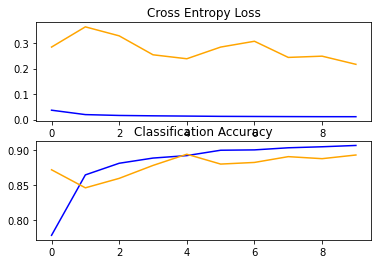

Accuracy: mean=89.306 std=0.000, n=1


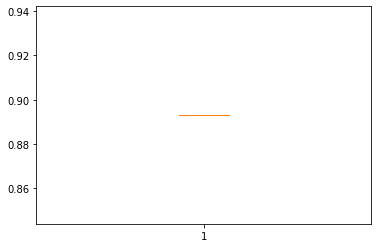

In [44]:
model = run_training()

In [45]:
%tensorboard --logdir=logs

# python -m tensorboard.main --logdir=logs  


UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# Export the model to tflite.

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# open('model.tflite', 'wb').write(tflite_model)

modelSaveName = _LETTERS + '_'+ _OTHER_LETTERS+'.tflite'
open(modelSaveName, 'wb').write(tflite_model)

In [ ]:
# Reload the tflite model


interpreter = tf.lite.Interpreter(modelSaveName)
# interpreter = tf.lite.Interpreter('model.tflite')
interpreter.allocate_tensors()
input_tensor = interpreter.tensor(interpreter.get_input_details()[0]["index"])
output_tensor = interpreter.tensor(interpreter.get_output_details()[0]["index"])
def classify(letter_image):
    input_tensor()[:] = letter_image
    interpreter.invoke()
    probabilities = softmax(output_tensor()[0])
    index = np.argmax(probabilities)
    if not index:
        return 'UNKNOWN', probabilities[index]
    return _LETTERS[index - 1],  probabilities[index]


In [ ]:
# Run the classifier on a few examples

print('M letters')
for i in range(3, 10):
    image = Image.open(f"evaluation/{i}_M.bmp")
    image = image.crop((0, 0, 28, 28))
    np_image = np.array(image, np.float32)
    np_image = np_image / 255.0
    # Apply a blur to the input image to look more like the emnist training set.
    np_image = blur(np_image)

    pyplot.imshow(np_image, cmap='gray')
    print(i, classify(np_image.reshape((1, 28, 28, 1))))
    del image

print('O letters')
for i in range(3, 21):
    image = Image.open(f"evaluation/{i}_O.bmp")
    image = image.crop((0, 0, 28, 28))
    np_image = np.array(image, np.float32)
    np_image = np_image / 255.0
    np_image = blur(np_image)
    np_image = np_image / np.max(np_image)

    pyplot.imshow(np_image, cmap='gray')
    print(i, classify(np_image.reshape((1, 28, 28, 1))))
    del image
